# Lab 3: Linear Regression

This workbook covers the fundamental linear regression model from a number of different angles. First we consider an analytic analysis and then we continue to consider how to solve the same problem using numerical methods.

In [1]:
%matplotlib inline
import numpy as np

# A new one for this lab!
import tensorflow as tf

from sklearn import datasets as ds

import matplotlib.pyplot as plt

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

C:\Users\aksha\Anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\aksha\Anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\aksha\Anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\aksha\Anaconda3\envs\tensorflow_cpu\l

In [2]:
boston = ds.load_boston()

x_raw = boston.data[:,np.argwhere(boston.feature_names == 'RM')[0,0]]
y_raw = boston.target

## Boston House Prices Dataset
A descroption of the dataset used is provided here.

Data Set Characteristics:  
    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
http://archive.ics.uci.edu/ml/datasets/Housing


This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
### References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.
   - many more! (see http://archive.ics.uci.edu/ml/datasets/Housing)

## Preparing the data

We are going to look at the relationship between the "average number of rooms per dwelling" and median house price in the Boston dataset. First let us partition the data into a training and test split. We are going for 60% training and 40% testing.

In [3]:
total_count = x_raw.shape[0]

split = int(total_count * 0.6)

# Shuffle the data to avoid any ordering bias..
np.random.seed(0)
shuffle = np.random.permutation(total_count)

x = x_raw[shuffle]
y = y_raw[shuffle]

x_train_unnormalised = x[:split]
y_train_unnormalised = y[:split]

x_test_unnormalised = x[split:]
y_test_unnormalised = y[split:]

print('Training set size:', x_train_unnormalised.shape[0])
print('Test set size:', x_test_unnormalised.shape[0])


Training set size: 303
Test set size: 203


## Data Visualisation

For this task will work with just one dimensional data set

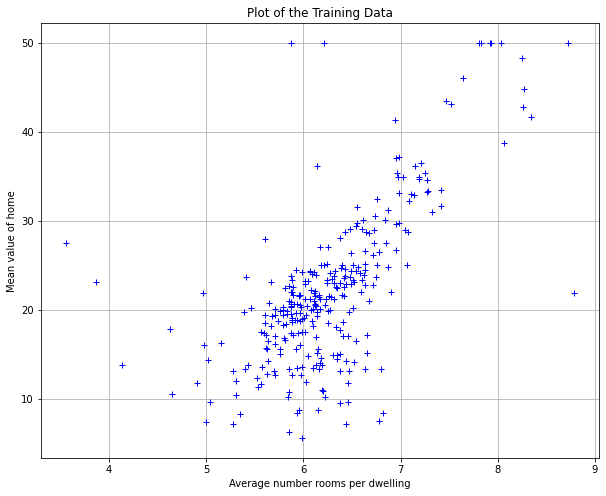

In [4]:
def plot_data(x, y):
    plt.figure(figsize=[10,8])
    plt.plot(x, y, 'b+')
    plt.grid(True)
    plt.title('Plot of the Training Data')
    plt.xlabel('Average number rooms per dwelling')
    plt.ylabel('Mean value of home')

plot_data(x_train_unnormalised, y_train_unnormalised)


Next will write a function that normalises a vector of values. It produces a vector where the values have a mean of zero and a standard deviation of 1. 

Passes checking function :)


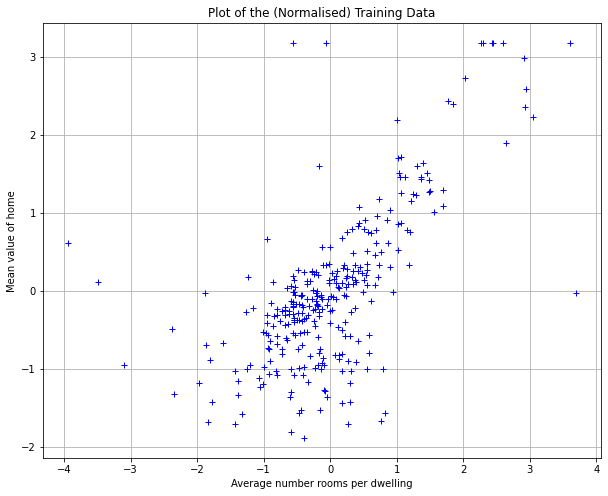

In [5]:
def normalise_data(x_unnormalised):
    
    a = np.std(x_unnormalised)
    b = np.mean(x_unnormalised)
    x_normalised = (x_unnormalised-b)/a

    return x_normalised, a, b

def unnormalise_data(x_normalised, a, b):

    x_unnormalised = (x_normalised * a)+b
    
    return x_unnormalised

try:
    x_train, x_norm_a, x_norm_b = normalise_data(x_train_unnormalised)
    y_train, y_norm_a, y_norm_b = normalise_data(y_train_unnormalised)

    x_test, _, _ = normalise_data(x_test_unnormalised)
    y_test, _, _ = normalise_data(y_test_unnormalised)

except Exception as err:
    
    print('Error during normalisation functions:', err)

def checking_function(normalise_data, unnormalise_data, data_to_check):
    passes_check = False
    
    est_normalised_data, est_a, est_b = normalise_data(data_to_check)
    est_unnormalised_data = unnormalise_data(est_normalised_data, est_a, est_b)

    
    assert np.all(np.isclose(data_to_check,est_unnormalised_data))
    
    passes_check = True

    return passes_check

try:
    if (checking_function(normalise_data, unnormalise_data, x_train_unnormalised) == True) and \
       (checking_function(normalise_data, unnormalise_data, y_train_unnormalised) == True):
        print('Passes checking function :)')
    else:
        print('Failed to pass the checking function :(')
except Exception as err:
    print('Error during checking function:', err)

# Plot the data to make sure they are normalised..
try:
    plot_data(x_train, y_train)
    plt.title('Plot of the (Normalised) Training Data')
except Exception as err:
    print('Error during ploting functions:', err)

## The Linear Regression Model

In linear regression we are trying to fit a linear model to the data of the form

\begin{align}
y &= w x + c
\end{align}

where $w$ and $c$ are parameters to be learned that take the input data $x$ to the output data $y$. Once this model has been learned, we can use the parameters to predict the values of the output that would correspond to new values of the input.

In order to determine the parameters, we need an objective function that we seek to optimise: this function returns a scalar value for all possible parameter values and we seek to change the parameters until the best scalar value is obtained.

For linear regression, we usually take the objective as one which minimises the squared error; this is known as a linear least squares problem.


Therefore our objective is given by the sum of squared differences between the true value of $y_i$ and the value estimated by our model $w x_i + c$.

\begin{align}
E(w,c) &= \sum_{i=0}^{N-1} \big(y_i - f(x_i) \big)^2 \\
    &= \sum_{i=0}^{N-1} \big(y_i - (w x_i + c) \big)^2 \\
    &= \sum_{i=0}^{N-1} \big(y_i - w x_i - c \big)^2
\end{align}



Next we will write a function that calculates the least squared error on the training data for a particular value of the parameters $w$ and $c$.

In [6]:
def least_squares_error(x, y, w, c):
    squared_error = ((y -(w*x +c))**2).sum(axis=0)
    return squared_error

try:
    print('Squared error for w = 1.5, c = 0.5 is ', 
          least_squares_error(x_train, y_train, w=1.5, c=0.5))
except Exception as err:
    print('Error during least squares calculation:', err)

Squared error for w = 1.5, c = 0.5 is  450.52041703162615


## Analytic Solution

In the case of linear regression, we can find an analytic solution to this problem by finding stationary point of the objective function. We do this by evaluating the partial derivatives of the objective wrt each parameter in turn and setting them to zero. If we can then find a solution to these simultaneous equations, we have found an optimal setting for the parameters.

For $w$ we have:

\begin{align}
\frac{\partial E}{\partial w} 
    &= \frac{\partial}{\partial w}\sum_{i=0}^{N-1} \big(y_i - w x_i - c \big)^2 \\
    &= \sum_{i=0}^{N-1} \frac{\partial}{\partial w} \big(y_i - w x_i - c \big)^2 \\
    &= \sum_{i=0}^{N-1} 2 \big(y_i - w x_i - c \big) \frac{\partial}{\partial w} \big(y_i - w x_i - c \big) \\
    &= \sum_{i=0}^{N-1} 2 \big(y_i - w x_i - c \big) \big(- x_i \big) \\
    &= \sum_{i=0}^{N-1} 2 x_i (w x_i + c - y_i) \\
\end{align}

For $c$ we have:

\begin{align}
\frac{\partial E}{\partial c} 
    &= \frac{\partial}{\partial c}\sum_{i=0}^{N-1} \big(y_i - w x_i - c \big)^2 \\
    &= \sum_{i=0}^{N-1} \frac{\partial}{\partial c} \big(y_i - w x_i - c \big)^2 \\
    &= \sum_{i=0}^{N-1} 2 \big(y_i - w x_i - c \big) \frac{\partial}{\partial c} \big(y_i - w x_i - c \big) \\
    &= \sum_{i=0}^{N-1} 2 \big(y_i - w x_i - c \big) \big(- 1 \big) \\
    &= \sum_{i=0}^{N-1} 2 (w x_i + c - y_i) \\
\end{align}

Now setting $\frac{\partial E}{\partial w} = 0$:

\begin{align}
\Rightarrow \sum_{i=0}^{N-1} x_i (w x_i + c - y_i) &= 0 \\
w \sum_{i=0}^{N-1} (x_i)^2 + c \sum_{i=0}^{N-1} (x_i) - \sum_{i=0}^{N-1} (x_i y_i) &= 0 \\
\Rightarrow A w + B c - C &= 0 \qquad\text{(1)}
\end{align}

with $A = \sum_{i=0}^{N-1} (x_i)^2$, $B = \sum_{i=0}^{N-1} (x_i)$ and $C = \sum_{i=0}^{N-1} (x_i y_i)$.

Now setting $\frac{\partial E}{\partial c} = 0$:

\begin{align}
\Rightarrow \sum_{i=0}^{N-1} (w x_i + c - y_i) &= 0 \\
w \sum_{i=0}^{N-1} (x_i) + N c - \sum_{i=0}^{N-1} (y_i) &= 0 \\
\Rightarrow B w + N c - D &= 0 \qquad\text{(2)}
\end{align}

with $D = \sum_{i=0}^{N-1} (y_i)$.

Equations (1) and (2) can be combined to solve for the optimal values for $w$ and $c$!

Next we write a function using numpy that takes as input `x_train` and `y_train` and outputs the optimal $w$ and $c$ parameters for least squares linear regression and plotting the results

Analytic solution:
Analytic w =  0.6710446457297836
Analytic c =  1.2195548195136355e-15
Mean least squares error on TRAINING data =  0.5496990834373895
Mean least squares error on TEST data =  0.477446115537434


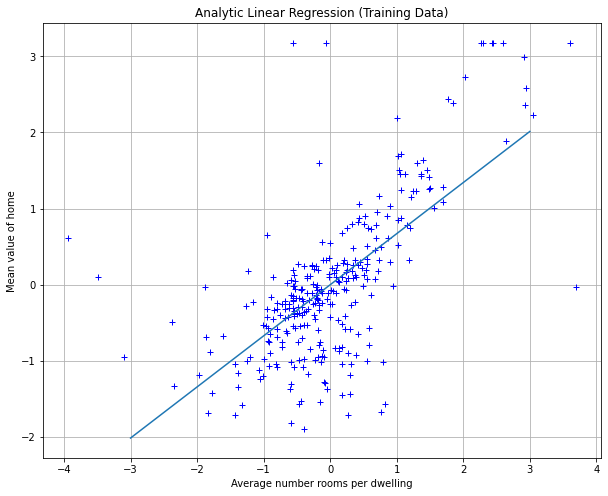

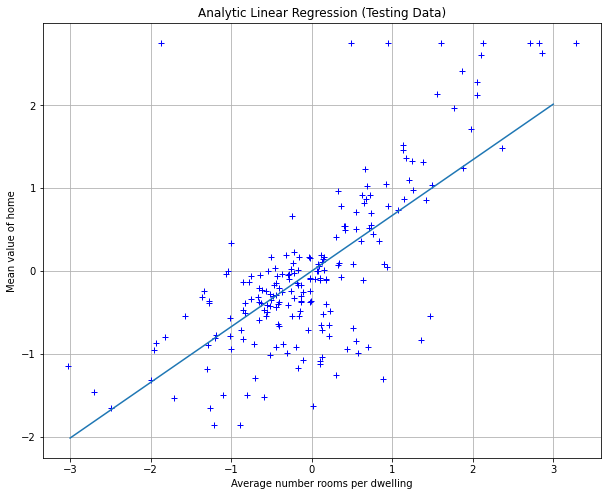

In [7]:
def least_squares_analytic_solution(x, y):

    A = np.sum(x**2)
    B = np.sum(x)
    C= np.sum(x*y)
    D = np.sum(y)
    N = len(x)

    c = ((C*B)-D*A)/(B**2-A*N-B)
    w = ((C*N)-D*B)/(A*N-B**2)
   
    return w, c


try:
    w_opt, c_opt = least_squares_analytic_solution(x_train, y_train)
    
    print('Analytic solution:')
    print('Analytic w = ', w_opt)
    print('Analytic c = ', c_opt)
    
except Exception as err:
    print('Error during least squares analytic solution:', err)

    
def plot_estimated_y_for_input_x(w, c, x_train):
    x_val = np.linspace(-3,3, num=20)
    plt.plot(x_val,(w*x_val+c), label='estimate')


try:
    plot_data(x_train, y_train)
    plt.title('Analytic Linear Regression (Training Data)')
    plot_estimated_y_for_input_x(w_opt, c_opt,x_train)
    
    print('Mean least squares error on TRAINING data = ',
          least_squares_error(x_train, y_train, w_opt, c_opt) / x_train.shape[0])

    plot_data(x_test, y_test)
    plt.title('Analytic Linear Regression (Testing Data)')
    plot_estimated_y_for_input_x(w_opt, c_opt,x_train)
    
    print('Mean least squares error on TEST data = ',
          least_squares_error(x_test, y_test, w_opt, c_opt) / x_test.shape[0])
    
except Exception as err:
    print('Error during plotting:', err)

In the previous question we looked at an analytic solution to the least square problem. We now pretend that we could not solve the problem analytically. Although this is not true for this case, the additional of extensions to the linear regression model (for example to improve robustness, adding feature selection or handling non-linear data) can mean that it is no longer possible to find an analytic solution and numerical optimisation must be used.

Next we will calculate the least squares error using tensorflow and check that it calculates the same value as the analytic vesrsion

In [8]:
tf.reset_default_graph()

try:
    # Constants to hold the training data..
    t_x_train = tf.constant(x_train, name='x_train')
    t_y_train = tf.constant(y_train, name='y_train')
except Exception as err:
    print('Error defining training data:', err)
    
# Initial values for optimisation..
w_initial_guess = 1.5
c_initial_guess = 0.5

# Variables to hold w and c
t_w = tf.Variable(w_initial_guess, 
                  dtype=tf.float64, 
                  name='w')
t_c = tf.Variable(c_initial_guess, 
                  dtype=tf.float64, 
                  name='c')

def calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c):

    squared_error = (t_y_train - t_w*t_x_train+t_c)**2
    t_least_squares_error = tf.reduce_sum(squared_error)
    
    return t_least_squares_error

try:
    t_least_squares_error = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c)
except Exception as err:
    print('Error declaration of calculate_tf_least_squares_error():', err)

try:
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())

        tensorflow_result = session.run(t_least_squares_error)

    # Check with the result from your previous function..
    numpy_result = least_squares_error(x_train, y_train, 
                                       w=w_initial_guess, 
                                       c=c_initial_guess)

    print('Tensorflow least squares error = ', tensorflow_result)
    print('numpy least squares error = ', numpy_result)

    # This should pass if they are the same to nummerical precision!
    assert(np.isclose(tensorflow_result, numpy_result))
except Exception as err:
    print('Error during optimisation with calculate_tf_least_squares_error():', err)

Tensorflow least squares error =  450.5204170316276
numpy least squares error =  450.52041703162615


Next we will write numpy code to calculate the value of the derivatives from the analytic expressions (derived previously):

\begin{align}
\frac{\partial E}{\partial w} 
    &= \sum_{i=0}^{N-1} 2 x_i (w x_i + c - y_i) \\
\end{align}

\begin{align}
\frac{\partial E}{\partial c} 
    &= \sum_{i=0}^{N-1} 2 (w x_i + c - y_i) \\
\end{align}

In [9]:
tf.reset_default_graph()

try:
    # Constants to hold the training data..
    t_x_train = tf.constant(x_train, name='x_train')
    t_y_train = tf.constant(y_train, name='y_train')
except Exception as err:
    print('Error defining training data:', err)
    
# Initial values for optimisation..
w_initial_guess = 1.5
c_initial_guess = 0.5

# Variables to hold w and c
t_w = tf.Variable(w_initial_guess, 
                  dtype=tf.float64, 
                  name='w')
t_c = tf.Variable(c_initial_guess, 
                  dtype=tf.float64, 
                  name='c')

try:
    t_least_squares_error = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())

        t_gradient_wrt_w = tf.gradients(t_least_squares_error, t_w)
        t_gradient_wrt_c = tf.gradients(t_least_squares_error, t_c)

        tf_grad_w = session.run(t_gradient_wrt_w)
        tf_grad_c = session.run(t_gradient_wrt_c)

        print('Tensorflow gradient wrt w = ', tf_grad_w)
        print('Tensorflow gradient wrt c = ', tf_grad_c)
except Exception as err:
    print('Error using calculate_tf_least_squares_error() to find gradients:', err)
    
def calc_gradients_for_least_squares(x, y, w, c):
    
    grad_w = np.sum(2*x*(w*x+c-y))
    grad_c =np.sum(2*(w*x+c-y).sum(axis=0))
    
    return grad_w, grad_c

try:
    numpy_grad_w, numpy_grad_c = calc_gradients_for_least_squares(x_train, 
                                                                  y_train, 
                                                                  w_initial_guess, 
                                                                  c_initial_guess)

    print('Analytic gradient wrt w = ', numpy_grad_w)
    print('Analytic gradient wrt c = ', numpy_grad_c)

    # This should pass if they are the same to nummerical precision!
    assert(np.isclose(tf_grad_w, numpy_grad_w))
    assert(np.isclose(tf_grad_c, numpy_grad_c))
except Exception as err:
    print('Error during calculation with calc_gradients_for_least_squares():', err)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Tensorflow gradient wrt w =  [502.3469446877517]
Tensorflow gradient wrt c =  [303.0000000000015]
Analytic gradient wrt w =  502.34694468775075
Analytic gradient wrt c =  302.99999999999847


Next the we will implement gradient Descent in Tensorflow

In [10]:
tf.reset_default_graph()

try:
    # Constants to hold the training data..
    t_x_train = tf.constant(x_train, name='x_train')
    t_y_train = tf.constant(y_train, name='y_train')
except Exception as err:
    print('Error defining training data:', err)
    
# Initial values for optimisation..
w_initial_guess = 1.5
c_initial_guess = 0.5

# Variables to hold w and c
t_w = tf.Variable(w_initial_guess, 
                  dtype=tf.float64, 
                  name='w')
t_c = tf.Variable(c_initial_guess, 
                  dtype=tf.float64, 
                  name='c')

try:
    t_least_squares_error = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c)

    # Create a gradient descent optimiser that uses a
    # certain step size (learning_rate)..
    optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.001)

    # We want to minimise the least squares error
    t_objective = t_least_squares_error

    # We want to optimise wrt w and c
    vars_to_optimise = [t_w, t_c]

    minimize_operation = optimiser.minimize(t_objective,
                                            var_list=vars_to_optimise)

    # Number of iterations to perform
    num_iterations = 15

    with tf.Session() as session:
        session.run(tf.global_variables_initializer())

        # Run a number of iterations of gradient descent..
        for iteration in range(num_iterations):
            # At each iteration evaluate the minimize_operation
            # to perform the gradient descent step and also
            # keep track of the current value..
            step, cost = session.run([minimize_operation, 
                                      t_least_squares_error])

            # Print out the value of log P every 10 iterations..
            #if ((iteration + 1) % 10 == 0):
            print('iter %4d, E(w,c) = %0.3f' % 
                      (iteration + 1, cost))

        # Get the final results of the optimisation..
        w_tf_opt = session.run(t_w)
        c_tf_opt = session.run(t_c)

        print('\nAfter tensorflow optimisation:')
        print('Tensorflow w = ', w_tf_opt)
        print('Tensorflow c = ', c_tf_opt)

    print('\nAnalytic solution:')
    print('Analytic w = ', w_opt)
    print('Analytic c = ', c_opt)
    
except Exception as err:
    print('Error using calculate_tf_least_squares_error():', err)

iter    1, E(w,c) = 450.520
iter    2, E(w,c) = 210.640
iter    3, E(w,c) = 173.402
iter    4, E(w,c) = 167.621
iter    5, E(w,c) = 166.724
iter    6, E(w,c) = 166.584
iter    7, E(w,c) = 166.563
iter    8, E(w,c) = 166.559
iter    9, E(w,c) = 166.559
iter   10, E(w,c) = 166.559
iter   11, E(w,c) = 166.559
iter   12, E(w,c) = 166.559
iter   13, E(w,c) = 166.559
iter   14, E(w,c) = 166.559
iter   15, E(w,c) = 166.559

After tensorflow optimisation:
Tensorflow w =  0.67104535526506
Tensorflow c =  4.2796953470088016e-07

Analytic solution:
Analytic w =  0.6710446457297836
Analytic c =  1.2195548195136355e-15


Finally we will implement gradient descent using numpy starting with the current_step_size as 0.1 and running for 200 iterations

In [11]:
# Keep track of parameter values over iterations..
w_current = w_initial_guess
c_current = c_initial_guess

try:
    # Keep track of the error..
    E_current = least_squares_error(x_train, y_train, w_current, c_current)
except Exception as err:
    print('Error defining training data:', err)

# Keep track of the step size..
current_step_size = 0.1

num_iterations = 20

converge_threshold = 1e-8

try:
    for iteration in range(num_iterations):

        def run_iteration(x_train, y_train, w_current, c_current, E_current, 
                          current_step_size, converge_threshold):

            # Set to True when converged..
            converged = False
            overstep = False
            # code to evaluate the gradients..

            w_grad, c_grad = calc_gradients_for_least_squares(x_train, y_train, w_current, c_current)
    

            # code to take a step in the direction of the negative
            # gradient proportional to the step size..

            w_new = w_current-current_step_size*w_grad 
            c_new = c_current-current_step_size*c_grad


            # code to evaluate and remember the squared error..

            E_new = least_squares_error(x_train, y_train, w_new, c_new)


            # code to check that error is decreasing and reduce step
            # size if not

            if E_current < E_new:
                current_step_size = current_step_size*0.1
                #if overstep go back to old w and c values  
                w_new = w_current
                c_new = c_current
                E_new = E_current
                overstep = True
                
            # code to check for convergence and terminate
            # the loop if converged..

            if overstep == False:
                if np.abs(E_current - E_new) < converge_threshold :
                    converged = True


            # Take the step
            w_current = w_new
            c_current = c_new
            E_current = E_new

            return w_current, c_current, E_current, current_step_size, converged


        w_current, c_current, E_current, current_step_size, converged = \
            run_iteration(x_train, y_train, w_current, c_current, E_current, 
                          current_step_size, converge_threshold)


        print('iteration %4d, E = %f, w = %f, c = %f' % 
              (iteration, E_current, w_current, c_current))
        
        if converged:
            # Break out of iteration loop
            print('Converged!')
            break
        
    print('\nAfter gradient descent optimisation:')
    print('Optimised w = ', w_current)
    print('Optimised c = ', c_current)

    print('\nAnalytic solution:')
    print('Analytic w = ', w_opt)
    print('Analytic c = ', c_opt)
    
except Exception as err:
        print('Error during run_iteration():', err)

iteration    0, E = 450.520417, w = 1.500000, c = 0.500000
iteration    1, E = 450.520417, w = 1.500000, c = 0.500000
iteration    2, E = 210.639884, w = 0.997653, c = 0.197000
iteration    3, E = 173.401790, w = 0.799728, c = 0.077618
iteration    4, E = 167.621097, w = 0.721746, c = 0.030581
iteration    5, E = 166.723726, w = 0.691021, c = 0.012049
iteration    6, E = 166.584421, w = 0.678915, c = 0.004747
iteration    7, E = 166.562796, w = 0.674146, c = 0.001870
iteration    8, E = 166.559439, w = 0.672266, c = 0.000737
iteration    9, E = 166.558918, w = 0.671526, c = 0.000290
iteration   10, E = 166.558837, w = 0.671234, c = 0.000114
iteration   11, E = 166.558825, w = 0.671119, c = 0.000045
iteration   12, E = 166.558823, w = 0.671074, c = 0.000018
iteration   13, E = 166.558822, w = 0.671056, c = 0.000007
iteration   14, E = 166.558822, w = 0.671049, c = 0.000003
iteration   15, E = 166.558822, w = 0.671046, c = 0.000001
Converged!

After gradient descent optimisation:
Optimis

Both the tensorflow and numpy models converge to the same values of w and c. we can now predict house prices on a test data set

In [12]:
data = pd.read_csv('test.csv')

x_train = np.array(data['x1'])
x_train = x_train[:int(x_train.shape[0]*0.8)]

y_train = np.array(data['y'])
y_train = y_train[:int(y_train.shape[0]*0.8)]

w_initial_guess = 1.5
c_initial_guess = 0.5

In [13]:
test = x_train*w_current +c_current
print(test)

[-1.27778874 -0.83809307 -0.77415677 ...  0.76642915  1.02906375
  1.07802801]
